# Распознавание главных паттернов поведения пользователя на сайте

Цель: настроить и обучить модель ML определять основные интерактивные (кликабельные) элементы взаимодействия пользователя с сайтом, основываясь на крупных не маркированных информационных структурах. 

## Обработка данных

Данные для обучения модели используются с репозитория https://github.com/balabit/Mouse-Dynamics-Challenge

Кластеры разбиты на юзеров, которые посещали отслеживаемый сайт. Активность юзеров разбита на сеансы.

In [3]:
# формирование матриц данных из локальных файлов с сессиями пользователей

import os
import numpy as np
import pandas as pd
from IPython.display import display, HTML

DATA_DIR = os.getcwd() + '/data/test_files/'
users_sessions = os.listdir(DATA_DIR)
all_sessions = {i: os.listdir(DATA_DIR + i) for i in users_sessions}
print('Количество пользователей: %s' % len(all_sessions.keys()))
print('Общее количество сессий: %s' % sum([len(v) for v in all_sessions.values()]))

Количество пользователей: 10
Общее количество сессий: 1612


## Поля каждого файла сеанса:

- <b>record timestamp</b>: прошедшее время (в секундах) с начала сеанса, записанное устройством мониторинга netork
- <b>client timestamp</b>: прошедшее время (в секундах) с начала сеанса, записанное клиентом RDP
- <b>button</b>: текущее состояние кнопок мыши
- <b>state</b>: дополнительная информация о текущем состоянии мыши
- <b>x</b>: координата x курсора на экране
- <b>y</b>: координата y курсора на экране

In [4]:
# создание матрицы данных из всех сеансов одного юзера

def get_user_sessions(num_user):
    session = list(all_sessions.keys())[num_user]
    user_files = [DATA_DIR + session + '/' + i for i in all_sessions[session]]
    return user_files


def file_to_list(file):
    with open(file) as f:
        lt = f.readlines()
    return lt

def make_user_dataset(user_files):
    dataset = []
    columns = False
    for i in user_files:
        dataset += file_to_list(i)[1:]
        if not columns:
            columns = [i.replace(' ', '_').replace('\n', '').split(',')
                       for i in file_to_list(i)[0:1]][0]
    dataset = [i.replace('\n', '').split(',') for i in dataset]
    data = pd.DataFrame(dataset, columns=columns)
    return data

## Срез необработанной таблицы данных

In [5]:
num_user = 0 # первый пользоваль в списке 
data = make_user_dataset(get_user_sessions(num_user))
display(data[:50])

,record_timestamp,client_timestamp,button,state,x,y
0,0.0,0.0,NoButton,Move,1003,446
1,0.207999944687,0.202000000048,NoButton,Move,975,456
2,0.306999921799,0.312000000384,NoButton,Move,844,585
3,0.420000076294,0.421000000089,NoButton,Move,498,603
4,0.522000074387,0.530000000261,NoButton,Move,482,583
5,0.634000062943,0.639000000432,NoButton,Move,490,573
6,0.901999950409,0.842000000179,NoButton,Move,501,565
7,1.01399993896,1.01400000043,NoButton,Move,437,775
8,1.14999985695,1.0290000001,NoButton,Move,418,818
9,1.14999985695,1.13800000027,NoButton,Move,274,968


 ## Поиск структуры и закономерностей в массиве данных

In [6]:
# отделение значений положения мышки с активными кликами
press = data[['state']].values == 'Pressed'
press = data[press]
XY = press[['x', 'y']]

# формирование словаря уникальных положений
XY_dict = [i[0] + ';' + i[1] for i in XY.values]
print('Общее количество положений, ', len(XY_dict)) 
print('Количество уникальных положений, ', len(set(XY_dict)))

Общее количество положений,  13645
Количество уникальных положений,  10621


In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## Визуализация эффективности обученной модели

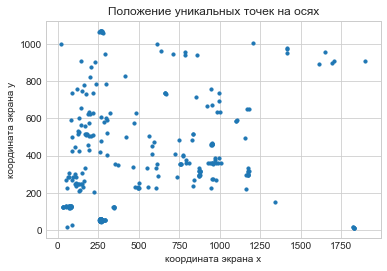

In [8]:
XY_set = pd.DataFrame(XY_dict, columns=['xy'])
XY_count = XY_set.xy.value_counts()
means = XY_count.mean()
XY_count = XY_count[XY_count > 2]
len(XY_count)
XY_count_dict = {x: y for x, y in zip(list(XY_count.index), list(XY_count.values))}
x = [int(i.split(';')[0]) for i in XY_count_dict.keys()]
y = [int(i.split(';')[1]) for i in XY_count_dict.keys()]

plt.scatter(x, y, s=10)
plt.title("Положение уникальных точек на осях")
plt.xlabel("координата экрана x")
plt.ylabel("координата экрана y")
plt.show()

## Настройка модели машинного обучения для поиска паттернов в структуре

Цель данного шага - кластеризация точек на экране в основные группы.
Группы-кластеры можно рассматривать как интерактивные элементы сайта, с которыми пользователь чаще всего взаимодейтсвует.

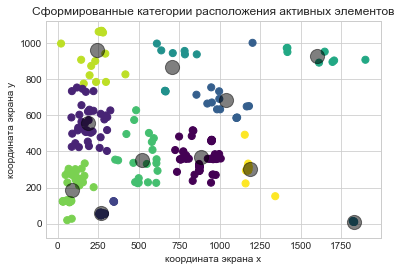

In [23]:
from sklearn.cluster import KMeans

X = np.hstack((np.array(x).reshape(len(x), 1), np.array(y).reshape(len(y), 1)))
# метод K-средних
kmeans = KMeans(n_clusters=11)
#Обучение модели
kmeans.fit(X)
# расставление меток
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("Сформированные категории расположения активных элементов")
plt.xlabel("координата экрана x")
plt.ylabel("координата экрана y")
plt.show()

В структуре данных найдено 11 основных категорий взаимодействия.

На графике выше точки окрашены согласно найденным кластерам.

Хорошо видно разделение между категориями.

Теперь обученная модель может распределять новую активность, и ранее не виденные точки согласно найденным закономерностям.

## Поиск самых активных элементов сайта согласно найденным категориям

In [19]:
y_kmeans_all = kmeans.predict(XY.values)
markers = pd.DataFrame(y_kmeans_all, columns=['label'])
m = markers.label.value_counts()

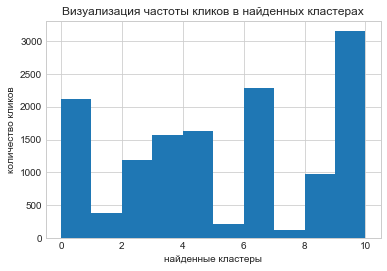

In [22]:
plt.hist(markers.label.values)
plt.title("Визуализация частоты кликов в найденных кластерах")
plt.xlabel("найденные кластеры")
plt.ylabel("количество кликов")
plt.show()

Глядя на гистограмму выше можно сразу отметить любопытный факт. 

Как видно, кластеры под номером 1 и 10 имеют наибольшее количество кликов.

Объясняется эта статистика тем, что X и Y положения мышки в данных кластеров соответствуют двум верхним углам экрана.

<b>кластер 1</b> - соответсвует левому верхнему углу монитора (где у пользователей linux находятся кнопки "закрыть", "скрыть", "свернуть")

<b>кластер 10</b> - соответсвует правому верхнему углу монитора (где у пользователей windows находятся вышеуказанный набор кнопок)
(тут же понятно, что пользователей винды было больше)

Вероятно предположить, что основное внимание пользователей приходилось на элементы, которые находидись в области кластеров 3, 4, 5 и главный фаворит интерактивного взаимодействия 7 кластер.


<i>напомню, модель ничего не знала о сайтах и страницах, на которых велась статистика кликов. структура воспроизводилась на динамике поведения пользователей</i>